In [1]:
%matplotlib inline
import sys
from lib.restartable_pendulum import RestartablePendulumEnv
from lib import state_rep_torch as srt
import gym
import numpy as np
from matplotlib import pyplot as plt
import torch
from lib import utils
from lib import encoder_wrappers as ew

array([[ 4.83058844e-02, -2.91281177e-03],
       [ 4.82945347e-02, -2.64957405e-03],
       [ 4.82945347e-02, -2.64957405e-03],
       [ 4.64195624e-02, -2.55683058e-03],
       [ 4.64195624e-02, -2.55683058e-03],
       [ 4.64195624e-02, -2.55683058e-03],
       [ 4.56744726e-02, -3.02216623e-03],
       [ 4.56744726e-02, -3.02216623e-03],
       [ 4.47247891e-02, -2.79583672e-03],
       [ 4.50202940e-02, -2.07245105e-03],
       [ 4.50202940e-02, -2.07245105e-03],
       [ 4.49367314e-02, -2.02933311e-03],
       [ 4.47579496e-02, -2.08344450e-03],
       [ 4.50975010e-02, -1.86844614e-03],
       [ 4.54145602e-02, -1.31187700e-03],
       [ 4.58953466e-02, -1.01883190e-03],
       [ 4.46607824e-02, -5.21492791e-04],
       [ 4.39548806e-02, -1.95372053e-05],
       [ 4.35836319e-02,  1.66565367e-05],
       [ 4.41994337e-02,  3.51022555e-05],
       [ 4.42591199e-02,  9.75761401e-05],
       [ 4.39170881e-02,  6.72351683e-04],
       [ 4.34005614e-02,  3.88986261e-04],
       [ 4.

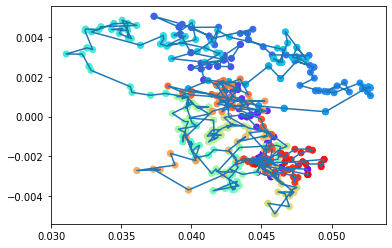

In [2]:


# specify environment information
n_repeats = 3 # step the environment this many times for each action, concatenate the pixel observations
env = RestartablePendulumEnv(repeats=n_repeats,pixels=True)


#nonlin = torch.nn.ELU()
nonlin = torch.nn.functional.relu
layers = [50, 10, 5] # architecture of encoder after the 2 conv layers
save_dir = "./"
n_episodes = 1000 # total batches to draw
batch_size = 25
learning_rate = .001
save_every = int(n_episodes/4) # save the model every so often

encnet = srt.ConvEncoderNet(layers,env.observation_space.shape[1:],sigma=nonlin)

# use the following commented out lines for PredictorNet (I changed deterministic sampling though...
#prednet = srt.PredictorNet(encnet,T,layers[-1],1)
#deterministic_args = (samples[i], batch_size, 35, method, n_repeats,T) 

prednet = srt.ForwardNet(encnet,layers[-1],1)
deterministic_args = None 

traj_sampler = srt.SimpleTrajectorySampler(env,
                                     srt.sample_pendulum_action_batch,
                                     srt.sample_pendulum_state_batch_old,
                                     device=torch.device("cpu"),
                                     deterministic=False,
                                     deterministic_args=deterministic_args)

net, losses = srt.train_encoder(prednet,traj_sampler,n_episodes,
                                batch_size=batch_size,
                                track_loss_every=int(n_episodes/100),
                                lr=learning_rate,
                                save_every=save_every,
                                save_path=save_dir)

torch.save(net,save_dir+"net")



# what follows is code to visualize the representations
d = 5 # must match the final entry in layers
n_samps = 500
env = ew.TorchEncoderWrapper(env,net.encoder,np.eye(d))
X = np.empty((n_samps,d))
for i,ang in enumerate(np.linspace(0,2*np.pi,n_samps)): # go through the angles from 0 to 2pi
    X[i,:] = env.reset(state=[ang,0])
utils.visualize_trajectory(X)

In [2]:
np.mean(np.asarray([[1,2],[3,4]]), axis=0)

array([2., 3.])